# metaBEAT analysis of Illumina MiSeq output for Li_et_al_2018

Mark sure your metaBEAT image version is the latest

`metaBEAT - metaBarcoding and Environmental DNA Analyses tool version: v.0.97.8-global`

Update from your terminal

####check the image, the latest ID should be 1f9e1e7d4566

sudo docker images
####if not, use the command to update the image from your terminal

sudo docker pull chrishah/metabeat


###The first step will be to trim/clean our raw Illumina data

In [1]:
!pwd

/home/working


In [2]:
!mkdir trimming

In [3]:
cd trimming

/home/working/trimming


__Prepare Querymap__


Prepare a text file specifying the samples to be processed including the format and location of the reads. 

The below command expects the Illumina data to be present in 2 fastq files (forward and reverse reads) per sample in a directory `./raw_reads/`. It expects the files to be named 'sampleID', followed by '_R1' or '_R2' to identify the forward/reverse read file respectively. 

The raw data need to be downloaded with `How_to_download_Rawdata_from_SRA.ipynb` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/raw_reads/How_to_download_Rawdata_from_SRA.ipynb))

SampleID must corresponds to the first column in the file `Sample_accessions.tsv` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/supplementary_data/Sample_accessions.tsv)), marker is '12S'.




In [4]:

%%bash

for a in $(cat ../supplementary_data/Sample_accessions.tsv | grep "12S" | cut -f 1 | grep "SampleID" -v)
do
    R1=$(ls -1 ../raw_reads/$a-12S_* | grep "_R1.fastq")
    R2=$(ls -1 ../raw_reads/$a-12S_* | grep "_R2.fastq")

    echo -e "$a\tfastq\t$R1\t$R2"
done > Querymap.txt

The resulting file should look e.g. like below:

In [5]:
!head Querymap.txt

T1-1-1	fastq	../raw_reads/T1-1-1-12S_R1.fastq.gz	../raw_reads/T1-1-1-12S_R2.fastq.gz
T1-1-2	fastq	../raw_reads/T1-1-2-12S_R1.fastq.gz	../raw_reads/T1-1-2-12S_R2.fastq.gz
T1-1-3	fastq	../raw_reads/T1-1-3-12S_R1.fastq.gz	../raw_reads/T1-1-3-12S_R2.fastq.gz
T1-1-4	fastq	../raw_reads/T1-1-4-12S_R1.fastq.gz	../raw_reads/T1-1-4-12S_R2.fastq.gz
T1-1-5	fastq	../raw_reads/T1-1-5-12S_R1.fastq.gz	../raw_reads/T1-1-5-12S_R2.fastq.gz
T1-2-1	fastq	../raw_reads/T1-2-1-12S_R1.fastq.gz	../raw_reads/T1-2-1-12S_R2.fastq.gz
T1-2-2	fastq	../raw_reads/T1-2-2-12S_R1.fastq.gz	../raw_reads/T1-2-2-12S_R2.fastq.gz
T1-2-3	fastq	../raw_reads/T1-2-3-12S_R1.fastq.gz	../raw_reads/T1-2-3-12S_R2.fastq.gz
T1-2-4	fastq	../raw_reads/T1-2-4-12S_R1.fastq.gz	../raw_reads/T1-2-4-12S_R2.fastq.gz
T1-2-5	fastq	../raw_reads/T1-2-5-12S_R1.fastq.gz	../raw_reads/T1-2-5-12S_R2.fastq.gz



The 12S amplicon sequenced here is only 106bp long. Readlength used in the MiSeq run was 2x250bp. Our reads are thus longer than our amplicon and we so expect to find primer/adapter sequences in our reads that need to be removed as part of the raw data processing. 

Specifically, forward reads are expected to contain the reverse complement of the reverse primer plus the reverse Illumina adapter (FA501-FA508; FB501-FB508), and reverse reads will contain reverse complements of the forward primers and adapters (RA701-RA712;RB701-RB712).

The expected sequences have been produced from `12S-adapters.fasta` (see [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/12S-adapters.fasta)) into reverse complements `12S-adapters_rc.fasta` and will be used in the trimming algorithm.

In [ ]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
for record in SeqIO.parse("../12S-adapters.fasta", "fasta"):
    print record.id + "_rc"
    print record.seq.reverse_complement()

def make_rc_record(record):
    """Returns a new SeqRecord with the reverse complement sequence."""
    return SeqRecord(seq = record.seq.reverse_complement(), \
                 id = record.id + "_rc", \
                 description = "reverse complement")

records = map(make_rc_record, SeqIO.parse("../12S-adapters.fasta", "fasta"))
SeqIO.write(records, "../12S-adapters_rc.fasta", "fasta")


In [7]:
!head -10 ../12S-adapters_rc.fasta

>FA501_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATACGTACGATGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA502_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATACAGATAGTGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA503_rc reverse complement
GGGGTATCTAATCCCAGTCCAATTACCATAACTCGCTAGTGTAGATCTCGGTGGTCGCCG
TATCATT
>FA504_rc reverse complement


###Raw data trimming, removal of adapter sequences and merging of reads using the `metaBEAT` pipeline

__The manual of metaBEAT_global.py can run the command as below__

!metaBEAT_global.py -h

In [8]:
%%bash

metaBEAT_global.py \
-Q Querymap.txt \
--trim_qual 30 \
--trim_adapter ../12S-adapters_rc.fasta \
--trim_minlength 90 \
--merge \
--product_length 110 \
--forward_only \
--read_crop 106 \
-@ haikuilee@gmail.com \
-n 5 -v &> log

__Query survival after trimming__

Some stats on the read counts before/after trimming, merging etc. are summarized for you in `metaBEAT_read_stats.csv`.

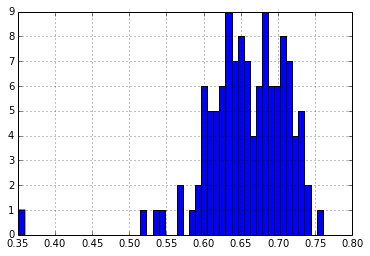

In [9]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('metaBEAT_read_stats.csv',index_col=0)
df['fraction'] = df['queries']/(df['total']*0.5)
df.fraction.hist(bins=50)

In [10]:
cd ../

/home/working


###Next stage of the processing is chimera detection and removal of putative chimeric sequences

We'll do that using `uchime` as implemented in `vsearch`.

In [11]:
!mkdir chimera_detection

In [12]:
cd chimera_detection

/home/working/chimera_detection


Convert reference database from Genbank to fasta format to be used in chimera detection.

Prepare Refmap file, i.e. text file that specifies the location and the format of the reference to be used.

The reference sequences in Genbank format should already be present in the `supplementary_data` directory: `12S_Fish_SATIVA_cleaned_May_2017.gb`.

In [13]:
%%bash

#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "12S_Fish_SATIVA_cleaned_May_2017.gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt



In [14]:
!cat REFmap.txt

../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb


In [ ]:
%%bash

metaBEAT_global.py \
-R REFmap.txt \
-f

In [16]:
!head -2 refs.fasta

>KC292935|7962|Cyprinus carpio
CCAGAAAAGAGAGATTTTAACTCTCACCCCTGGCTCCCAAAGCCAGAATTCTAAACTAAACTATTTTCTGGGGAGGTAGCACTCCCTTTATGGTATAGTACATATTATGCATAATATTACATTAATGTATTAGTACATATATGTATTATCACCAACTCACTATTTTAACCATAAAGCAGGTACATAATATTAAGGTGGGCATAAAGCATATTATTAAGACTCACAAATTCTATTATTTGGACTTGAGTAATATATTAATCCCCAAAAATTTGTCCTCAAATTTTTCCTTGAAATAATCAACTATAATTCCATTTAAACATATTAATGTAGTAAGAGACCACCAACCAGTTTATATAAAGGTATATCATGAATGATAGAATCAAGGACAATAATTGTGAGGGTTACACAATATGAACTATTACTGGCATCTGGTTCCTATTTCAGGGACATAACTGTAATATTCCACCCTCGGATAATTATACTGGCATCTGATTAATGGTGTAAGTACATACGTTTCATTACCCCCCATGCCGAGCATTCTTTTATATGCATAAGGTATTTTTTATTGGTTTCCTTTCATCTGGCATTTCAGAGTGCAGGCTCAAATGTTAAATCAAGGTTGAACATTTTCCTTGTATGTGATAATATATATTAATTATCGTAAGACATAATTTAAGAATTACATACTTTTATCTCAAGTGCATAATATATCTGTCTCTAGTTCAACTTATCCTTACATAGTGCCCCCTTTGGTTTTTGCGCGACAAACCCCCTTACCCCCTACGCTCAGCGAATCCTGTTATCCTTGTCAAACCCCGAAACCAAGGAGGACCCAAGAACGTGTAAACCAACGAGTTGAGGTATAAATTGGCATCCCATTATATATATATATATATATGCATCGGTTTTTTTAACCGCAACTTACCACTTACCTAAAAGCCCCTACCAAAAATCCCCAAAAAGAGGCTC

This will produce `refs.fasta`.

Now run chimera detection.

In [ ]:
%%bash


for a in $(cut -f 1 ../trimming/Querymap.txt)
do
    if [ -s ../trimming/$a/$a\_trimmed.fasta ]
    then
        echo -e "\n### Detecting chimeras in $a ###\n"
        mkdir $a
        cd $a
        vsearch --uchime_ref ../../trimming/$a/$a\_trimmed.fasta --db ../refs.fasta \
        --nonchimeras $a-nonchimeras.fasta --chimeras $a-chimeras.fasta &> log
        cd ..

    else
        echo -e "$a is empty"
    fi
done




###Last step is taxonomic assignment of reads based on a BLAST - LCA approach using the metaBEAT pipeline

In [18]:
cd ..

/home/working


In [19]:
!mkdir non-chimeras

In [20]:
cd non-chimeras/

/home/working/non-chimeras


__Prepare Querymap and Refmap txt files__

In [21]:
%%bash

#Querymap
for a in $(ls -l ../chimera_detection/ | grep "^d" | perl -ne 'chomp; @a=split(" "); print "$a[-1]\n"')
do
   if [ "$a" != "GLOBAL" ]
   then
      echo -e "$a-nc\tfasta\t../chimera_detection/$a/$a-nonchimeras.fasta"
   fi
done > Querymap.txt


#Write REFmap
for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "12S_Fish_SATIVA_cleaned_May_2017.gb$")
do
      echo -e "$file\tgb"
done > REFmap.txt

for file in $(ls -1 ../supplementary_data/reference_DBs/* | grep "Astatotilapia_calliptera.gb$")
do
      echo -e "$file\tgb"      
      
done >> REFmap.txt

In [22]:
!head Querymap.txt

T1-1-1-nc	fasta	../chimera_detection/T1-1-1/T1-1-1-nonchimeras.fasta
T1-1-2-nc	fasta	../chimera_detection/T1-1-2/T1-1-2-nonchimeras.fasta
T1-1-3-nc	fasta	../chimera_detection/T1-1-3/T1-1-3-nonchimeras.fasta
T1-1-4-nc	fasta	../chimera_detection/T1-1-4/T1-1-4-nonchimeras.fasta
T1-1-5-nc	fasta	../chimera_detection/T1-1-5/T1-1-5-nonchimeras.fasta
T1-2-1-nc	fasta	../chimera_detection/T1-2-1/T1-2-1-nonchimeras.fasta
T1-2-2-nc	fasta	../chimera_detection/T1-2-2/T1-2-2-nonchimeras.fasta
T1-2-3-nc	fasta	../chimera_detection/T1-2-3/T1-2-3-nonchimeras.fasta
T1-2-4-nc	fasta	../chimera_detection/T1-2-4/T1-2-4-nonchimeras.fasta
T1-2-5-nc	fasta	../chimera_detection/T1-2-5/T1-2-5-nonchimeras.fasta


In [23]:
!cat REFmap.txt

../supplementary_data/reference_DBs/12S_Fish_SATIVA_cleaned_May_2017.gb	gb
../supplementary_data/reference_DBs/Astatotilapia_calliptera.gb	gb


__Sequence clustering and taxonomic assignment via metaBEAT__

In [24]:
%%bash

metaBEAT_global.py \
-Q Querymap.txt \
-R REFmap.txt \
--cluster --clust_match 1 --clust_cov 3 \
--blast --min_ident 1 \
-m 12S -n 5 \
-E -v \
-@ haikuilee@gmail.com \
-o 12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0 &> log

Final result of taxonomic assignment can be found in the table `12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.tsv` (see also [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/supplementary_data/assignment_results/12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.tsv)). 

metaBEAT also produced the final result in [BIOM](http://biom-format.org/) format (`12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.biom`  see also [here](https://github.com/HullUni-bioinformatics/Li_et_al_2017/blob/master/supplementary_data/assignment_results/12S-trim_30-merged-nonchimeras-cluster_1c3-blast-min_ident_1.0-by-taxonomy-readcounts.blast.biom)), which can be analyzed with a number of tools and visually explored e.g. using [Phinch](http://phinch.org/).